# Sport articles classification

V rámci řešení této úlohy vycházím z toho, že pracuji s textovými daty – konkrétně s názvy článků a jejich perexy, ke kterým jsou přiřazené kategorie.

Prvním krokem je převod textu do číselné podoby pomocí vektorizace. Po tomto kroku vznikne velmi rozsáhlý a řídký prostor příznaků, kde každý dokument obsahuje velké množství tokenů, ale většina z nich má nulovou hodnotu. Tomu přizpůsobuji i volbu modelu – planuju použít lineární klasifikátory, konkrétně logistickou regresi nebo Linear SVC, které jsou pro tento typ dat vhodné a dlouhodobě se v textové klasifikaci osvědčují.

Počítám také s tím, že kategorie v datech nejsou rovnoměrně zastoupené. Některé se vyskytují výrazně častěji než jiné, a proto nechci hodnotit model pomocí accuracy. Jako hlavní metriku budu používat macro F1 skóre, které mi umožní posoudit výkon modelu napříč všemi třídami bez zvýhodnění těch nejčastějších.

Pro vektorizaci textu plánuji použít TF-IDF. Tento přístup mi umožní potlačit obecná a často se opakující slova a naopak zvýraznit výrazy, které jsou pro jednotlivé články více informativní. Zároveň budu testovat různá nastavení TF-IDF, například omezení minimální a maximální četnosti termínů, abych našel kompromis mezi velikostí prostoru příznaků a schopností modelu zobecňovat.

Název článku a perex budu spojovat do jednoho textového vstupu. Titulek často nese hlavní informaci o tématu, zatímco perex poskytuje doplňující kontext, a jejich kombinací chci nechat modelu prostor, aby si sám určil, jaký význam jednotlivým částem přisoudí.

## Imports

In [1]:

import glob
import os
import joblib


import mlflow
import mlflow.sklearn
import pandas as pd
from huggingface_hub import snapshot_download


from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold, train_test_split
from sklearn.naive_bayes import ComplementNB
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.metrics import f1_score
from sklearn.pipeline import FeatureUnion



from utility import run_mlflow_experiment, run_mlflow_validation_only


/Users/kazakovalexey/Documents/Coding/ls_26_2/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Get data

### Download from Hugging face repo

In [2]:
snapshot_download(
    repo_id="marekk/testing_dataset_article_category",
    repo_type="dataset",
    local_dir="./raw_data",
    local_dir_use_symlinks=False,
)


/Users/kazakovalexey/Documents/Coding/ls_26_2/.venv/lib/python3.12/site-packages/huggingface_hub/utils/_validators.py:202: UserWarning: The `local_dir_use_symlinks` argument is deprecated and ignored in `snapshot_download`. Downloading to a local directory does not use symlinks anymore.
  warnings.warn(
Fetching 8 files: 100%|██████████| 8/8 [00:00<00:00, 16124.19it/s]


'/Users/kazakovalexey/Documents/Coding/ls_26_2/raw_data'

### Upload to pandas df

In [3]:
DATA_DIR = "./raw_data"
csv_paths = sorted(glob.glob(os.path.join(DATA_DIR, "*.csv")))
dfs = []
for p in csv_paths:
    df = pd.read_csv(p)
    df["source_file"] = os.path.basename(p)
    dfs.append(df)

data = pd.concat(dfs, ignore_index=True)

## Explaratory Analysis

In [4]:
print("Raw shape:", data.shape)
data.head()

Raw shape: (1500, 4)


,title,perex,label,source_file
0,Realu se vážně zranil Asensio. Ceballos by měl...,Real Madrid potenciálně na celý ročník 2019/20...,Injuries,injuries.csv
1,Problémy s koleny dohnaly Richardse k brzkému ...,Už ve 31 letech dohnaly neustálé problémy s ko...,Injuries,injuries.csv
2,Verletzungspech bei Real - Kreuzband-Schock fü...,Schock bei Real Madrid! Marco Asensio erlitt i...,Injuries,injuries.csv
3,Man Utd star Eric Bailly to miss ‘at least six...,MANCHESTER UNITED star Eric Bailly is set to m...,Injuries,injuries.csv
4,Вутов под въпрос за мача с Левски,Един от основните футболисти на Ботев (Пловдив...,Injuries,injuries.csv


In [5]:
data.groupby("label").count()

,title,perex,source_file
label,,,
Injuries,100,100,100
Interview,100,100,100
Pre-Match,100,99,100
Reaction,1000,1000,1000
Report,100,100,100
Transfers,100,100,100


U sloupce „label“ je patrná nevyváženost tříd, přičemž label „reaction“ se v datech vyskytuje výrazně častěji než ostatní. Ve sloupci „pre-match“ se navíc nachází jedna chybějící hodnota.
S nevyvážeností tříd pravděpodobně nebudu nijak zásadně pracovat, maximálně zkusím downsampling. Upřímně tomu moc nevěřím, ale pro ověření to vyzkouším.
Chybějící hodnotu buď jednoduše odstraním spolu s celým řádkem, nebo se pokusím dohledat odpovídající článek na internetu a hodnotu doplnit.

### Handling missing data

In [6]:
data.loc[data["label"] == "Pre-Match"].sort_values(by="perex", ascending=True).tail(1)

,title,perex,label,source_file
201,Slavia i Sparta chtějí v pohárovém derby odčin...,NaN,Pre-Match,prematch.csv


#### Found missing text on the internet

Ten článek jsem nakonec dohledal tady 🙂
https://www.tyden.cz/rubriky/sport/fotbal/slavia-i-sparta-chteji-v-poharovem-derby-odcinit-ligove-porazky_520306.html

In [7]:
missing_text = """Domácí fotbalový pohár MOL Cup pozná ve středu finalisty. V prvním semifinále se utkají Ostrava s Bohemians 
                1905 a poté se v Edenu odehraje druhé ze tří jarních pražských derby mezi obhájcem trofeje Slavií a Spartou. 
                Oba celky, které se před devíti dny rozešly v lize smírně 1:1, budou chtít v poháru odčinit nedělní ligové porážky."""

In [8]:
data.loc[201, "perex"] = missing_text


In [9]:
data.loc[201,:]

title          Slavia i Sparta chtějí v pohárovém derby odčin...
perex          Domácí fotbalový pohár MOL Cup pozná ve středu...
label                                                  Pre-Match
source_file                                         prematch.csv
Name: 201, dtype: object

In [10]:
data.groupby("label").count()

,title,perex,source_file
label,,,
Injuries,100,100,100
Interview,100,100,100
Pre-Match,100,100,100
Reaction,1000,1000,1000
Report,100,100,100
Transfers,100,100,100


## Feature Engineering

### Create combined text

Sloučím title a perex do jednoho sloupce text, abych modelu poskytl více kontextu a zlepšil tak jeho schopnost rozlišovat mezi třídami.

In [11]:
data["text"] = "[TITLE] " + data["title"].str.strip() + " [PEREX] " + data["perex"].str.strip()


In [12]:
data.head(5)

,title,perex,label,source_file,text
0,Realu se vážně zranil Asensio. Ceballos by měl...,Real Madrid potenciálně na celý ročník 2019/20...,Injuries,injuries.csv,[TITLE] Realu se vážně zranil Asensio. Ceballo...
1,Problémy s koleny dohnaly Richardse k brzkému ...,Už ve 31 letech dohnaly neustálé problémy s ko...,Injuries,injuries.csv,[TITLE] Problémy s koleny dohnaly Richardse k ...
2,Verletzungspech bei Real - Kreuzband-Schock fü...,Schock bei Real Madrid! Marco Asensio erlitt i...,Injuries,injuries.csv,[TITLE] Verletzungspech bei Real - Kreuzband-S...
3,Man Utd star Eric Bailly to miss ‘at least six...,MANCHESTER UNITED star Eric Bailly is set to m...,Injuries,injuries.csv,[TITLE] Man Utd star Eric Bailly to miss ‘at l...
4,Вутов под въпрос за мача с Левски,Един от основните футболисти на Ботев (Пловдив...,Injuries,injuries.csv,[TITLE] Вутов под въпрос за мача с Левски [PER...


## Training

### Train, test,val split

train - 80%
test - 15%
validate - 5%

In [13]:
X = data["text"].values
y = data["label"].values

X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.25, random_state=42, stratify=y_temp
)

print("Train:", len(X_train))
print("Valid:", len(X_val))
print("Test :", len(X_test))


Train: 1200
Valid: 225
Test : 75


### Set up MLFlow

In [14]:
mlflow.set_tracking_uri("http://127.0.0.1:5000")
mlflow.set_experiment("Sport Articles Classification ")

<Experiment: artifact_location='mlflow-artifacts:/6', creation_time=1771155892948, experiment_id='6', last_update_time=1771155892948, lifecycle_stage='active', name='Sport Articles Classification ', tags={}>

### Training BaselineModel

#### Define pipeline

In [15]:
vectorizer = TfidfVectorizer(
    analyzer="word",
    ngram_range=(1, 3),
    min_df=2,
    max_df=0.9,
    lowercase=True
)

clf = LinearSVC(
    class_weight="balanced",
    random_state=42
)

model = Pipeline([
    ("tfidf", vectorizer),
    ("clf", clf)
])

model



,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('tfidf', ...), ('clf', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"input input: {'filename', 'file', 'content'}, default='content'- If `'filename'`, the sequence passed as an argument to fit is expected to be a list of filenames that need reading to fetch the raw content to analyze.- If `'file'`, the sequence items must have a 'read' method (file-like object) that is called to fetch the bytes in memory.- If `'content'`, the input is expected to be a sequence of items that can be of type string or byte.",'content'
,"encoding encoding: str, default='utf-8'If bytes or files are given to analyze, this encoding is used todecode.",'utf-8'
,"decode_error decode_error: {'strict', 'ignore', 'replace'}, default='strict'Instruction on what to do if a byte sequence is given to analyze thatcontains characters not of the given `encoding`. By default, it is'strict', meaning that a UnicodeDecodeError will be raised. Othervalues are 'ignore' and 'replace'.",'strict'
,"strip_accents strip_accents: {'ascii', 'unicode'} or callable, default=NoneRemove accents and perform other character normalizationduring the preprocessing step.'ascii' is a fast method that only works on characters that havea direct ASCII mapping.'unicode' is a slightly slower method that works on any characters.None (default) means no character normalization is performed.Both 'ascii' and 'unicode' use NFKD normalization from:func:`unicodedata.normalize`.",None
,"lowercase lowercase: bool, default=TrueConvert all characters to lowercase before tokenizing.",True
,"preprocessor preprocessor: callable, default=NoneOverride the preprocessing (string transformation) stage whilepreserving the tokenizing and n-grams generation steps.Only applies if ``analyzer`` is not callable.",None
,"tokenizer tokenizer: callable, default=NoneOverride the string tokenization step while preserving thepreprocessing and n-grams generation steps.Only applies if ``analyzer == 'word'``.",None


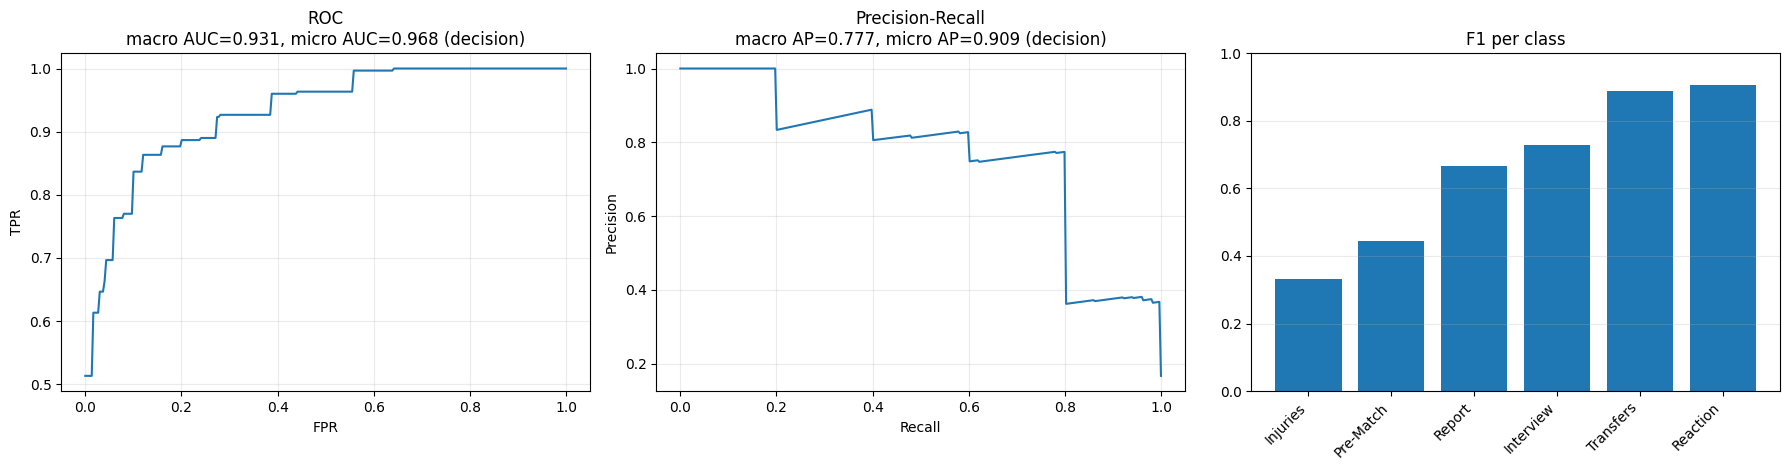

,accuracy,balanced_accuracy,f1_weighted
split,,,
train,0.995833,0.993333,0.995837
test,0.826667,0.626667,0.807814


/Users/kazakovalexey/Documents/Coding/ls_26_2/.venv/lib/python3.12/site-packages/mlflow/models/model.py:1209: FutureWarning: Saving scikit-learn models in the pickle or cloudpickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization.The recommended safe alternative is the 'skops' format.
  flavor.save_model(path=local_path, mlflow_model=mlflow_model, **kwargs)


Run ID: b32c27677f564b04a47101e633dfa700
🏃 View run tfidf_charwb_3_5_linearsvc_20260216_141527 at: http://127.0.0.1:5000/#/experiments/6/runs/b32c27677f564b04a47101e633dfa700
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/6
Run ID: b32c27677f564b04a47101e633dfa700


In [16]:

params = {
    "model_type": "LinearSVC",
    "vectorizer": "TfidfVectorizer(char_wb)",
    "ngram_range": str((4, 6)),
    "min_df": 2,
    "max_df": 0.9,
    "class_weight": "balanced",
    "random_state": 42,
    "train_size": len(X_train),
    "valid_size": len(X_val),
    "test_size": len(X_test), 
    "num_labels": int(pd.Series(y_train).nunique()),
    "source_files": ",".join(sorted(data["source_file"].unique())),
}

run_id = run_mlflow_experiment(
    model=model,
    run_name_prefix="tfidf_charwb_3_5_linearsvc",
    params=params,
    X_train=X_train,
    y_train=y_train,
    X_test=X_test,
    y_test=y_test,
    artifacts_dir="artifacts",
    log_model=True,
)

print("Run ID:", run_id)


Výsledky jsou dobré a v tomto nastavení očekávané. Model s TF-IDF a SVC se velmi dobře naučil trénovací data, protože TF-IDF silně zvýrazňuje vzácná a pro třídy specifická slova. Na testovacích datech se ale tyto vzácné výrazy nemusí objevovat nebo se hůře zobecňují, zejména u menšinových tříd. Proto klesá balanced accuracy, zatímco celková přesnost a vážené F1 zůstávají relativně vysoké.

### Attempt to beat baseline

### Add regularization

In [17]:
vectorizer = TfidfVectorizer(
    analyzer="char_wb",
    ngram_range=(4, 6),
    min_df=2,
    max_df=0.9,
    lowercase=True,
)

clf = LinearSVC(
    C=0.3,  
    loss="squared_hinge",
    class_weight="balanced",
    tol=1e-4,
    random_state=42,
)

model = Pipeline([
    ("tfidf", vectorizer),
    ("clf", clf),
])


In [18]:
params = {
    "model_type": "LinearSVC",
    "vectorizer": "TfidfVectorizer(char_wb)",
    "ngram_range": str((4, 6)),
    "min_df": 2,
    "max_df": 0.9,

    "C": 0.3,
    "loss": "squared_hinge",
    "penalty": "l2",

    "class_weight": "balanced",
    "random_state": 42,
    "tol": 1e-4,

    "train_size": len(X_train),
    "test_size": len(X_test),
    "num_labels": int(pd.Series(y_train).nunique()),
    "source_files": ",".join(sorted(data["source_file"].unique())),
}


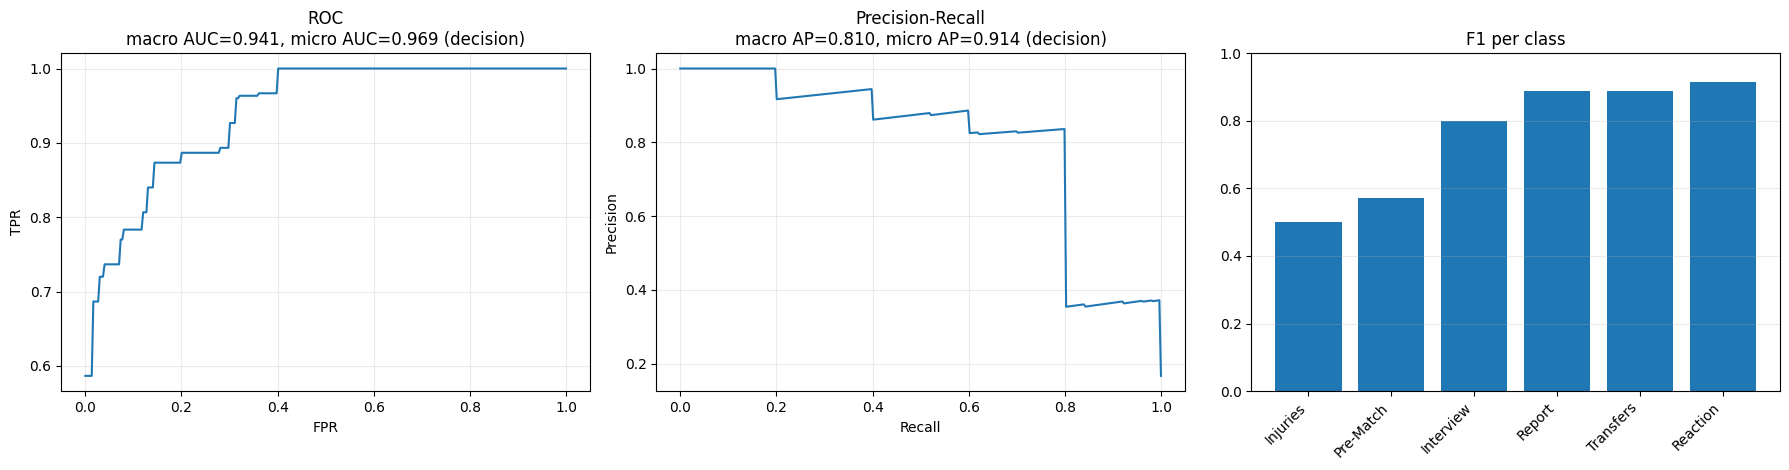

,accuracy,balanced_accuracy,f1_weighted
split,,,
train,0.992500,0.992500,0.992537
test,0.866667,0.696667,0.853872


/Users/kazakovalexey/Documents/Coding/ls_26_2/.venv/lib/python3.12/site-packages/mlflow/models/model.py:1209: FutureWarning: Saving scikit-learn models in the pickle or cloudpickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization.The recommended safe alternative is the 'skops' format.
  flavor.save_model(path=local_path, mlflow_model=mlflow_model, **kwargs)


Run ID: 6e42cc517ab44082ab3ca0903af1c98b
🏃 View run tfidf_charwb_4_6_linearsvc_reg_20260216_141530 at: http://127.0.0.1:5000/#/experiments/6/runs/6e42cc517ab44082ab3ca0903af1c98b
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/6
Run ID: 6e42cc517ab44082ab3ca0903af1c98b


In [19]:
run_id = run_mlflow_experiment(
    model=model,
    run_name_prefix="tfidf_charwb_4_6_linearsvc_reg",
    params=params,
    X_train=X_train,
    y_train=y_train,
    X_test=X_test,
    y_test=y_test,
    artifacts_dir="artifacts",
    log_model=True,
)

print("Run ID:", run_id)


Snížil jsem hodnotu parametru C z defaultní hodnoty 1 na 0.3, což by teoreticky mělo omezit overfitting tím, že model více regularizuje. Nicméně v tomto případě to téměř nemělo vliv, protože TF-IDF generuje velmi vysokodimenzionální a řídké vektory, které už samy o sobě fungují jako forma regularizace.

#### Define TF-IDF configurations to try

In [20]:
tfidf_configs = [
    # ---------- CHAR ONLY ----------
    {
        "name": "char_wb_3_5",
        "type": "single",
        "vectorizer": dict(
            analyzer="char_wb",
            ngram_range=(3, 5),
            min_df=2,
            max_df=0.9,
            lowercase=True,
        ),
    },
    {
        "name": "char_wb_4_6",
        "type": "single",
        "vectorizer": dict(
            analyzer="char_wb",
            ngram_range=(4, 6),
            min_df=2,
            max_df=0.9,
            lowercase=True,
        ),
    },

    # ---------- WORD ONLY ----------
    {
        "name": "word_1_2",
        "type": "single",
        "vectorizer": dict(
            analyzer="word",
            ngram_range=(1, 2),
            min_df=2,
            max_df=0.9,
            lowercase=True,
        ),
    },
    {
        "name": "word_1_3",
        "type": "single",
        "vectorizer": dict(
            analyzer="word",
            ngram_range=(1, 3),
            min_df=2,
            max_df=0.9,
            lowercase=True,
        ),
    },

    # ---------- CHAR + WORD ----------
    {
        "name": "char3_5_plus_word1_2",
        "type": "union",
        "vectorizers": {
            "char": dict(
                analyzer="char_wb",
                ngram_range=(3, 5),
                min_df=2,
                max_df=0.9,
                lowercase=True,
            ),
            "word": dict(
                analyzer="word",
                ngram_range=(1, 2),
                min_df=2,
                max_df=0.9,
                lowercase=True,
            ),
        },
    },
]


#### Loop over TF_IDF configurations with SVC


🚀 Running experiment: char_wb_3_5


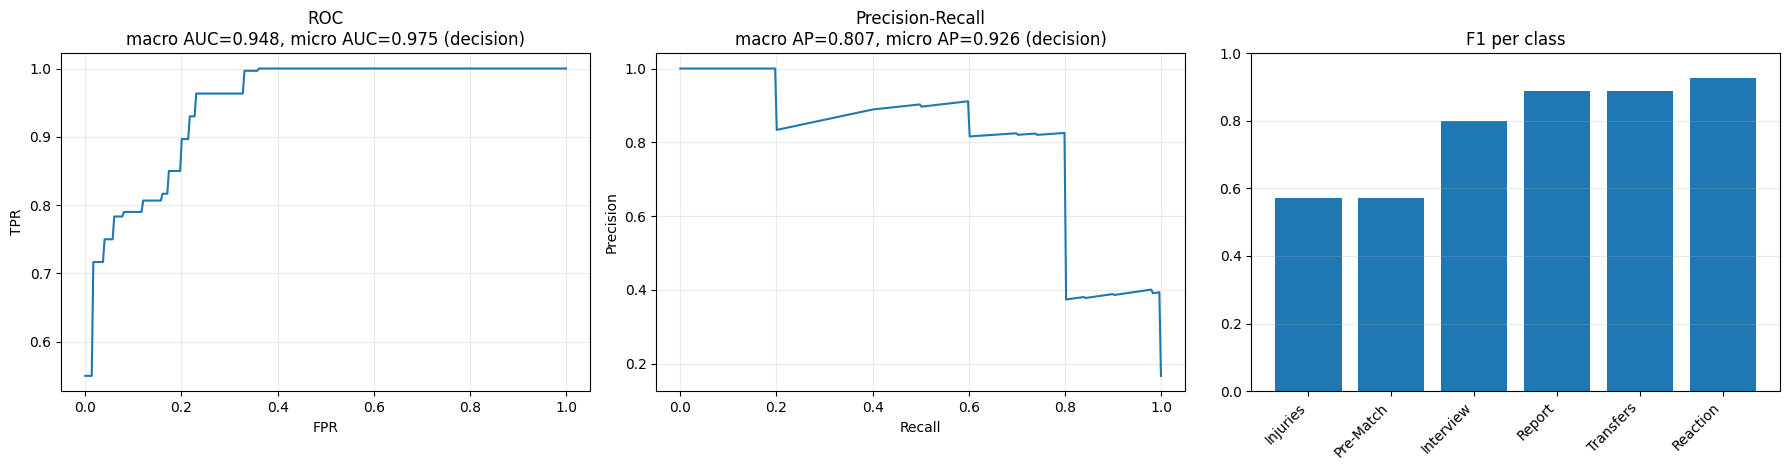

,accuracy,balanced_accuracy,f1_weighted
split,,,
train,0.995,0.993125,0.995005
test,0.880,0.700000,0.865326


/Users/kazakovalexey/Documents/Coding/ls_26_2/.venv/lib/python3.12/site-packages/mlflow/models/model.py:1209: FutureWarning: Saving scikit-learn models in the pickle or cloudpickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization.The recommended safe alternative is the 'skops' format.
  flavor.save_model(path=local_path, mlflow_model=mlflow_model, **kwargs)


Run ID: 1ec62e96cb924a40997885e2ce41cd67
🏃 View run tfidf_char_wb_3_5_linearsvc_20260216_141534 at: http://127.0.0.1:5000/#/experiments/6/runs/1ec62e96cb924a40997885e2ce41cd67
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/6

🚀 Running experiment: char_wb_4_6


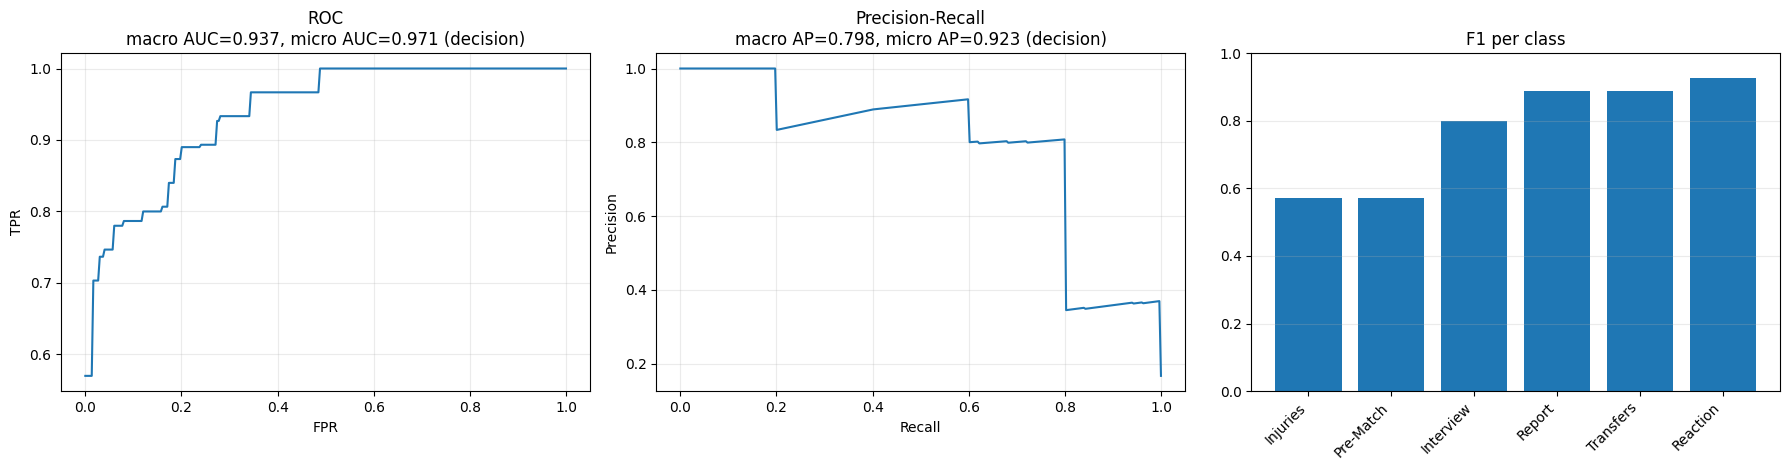

,accuracy,balanced_accuracy,f1_weighted
split,,,
train,0.995,0.993125,0.995005
test,0.880,0.700000,0.865326


/Users/kazakovalexey/Documents/Coding/ls_26_2/.venv/lib/python3.12/site-packages/mlflow/models/model.py:1209: FutureWarning: Saving scikit-learn models in the pickle or cloudpickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization.The recommended safe alternative is the 'skops' format.
  flavor.save_model(path=local_path, mlflow_model=mlflow_model, **kwargs)


Run ID: b8bd166726c441279a48e305da487e80
🏃 View run tfidf_char_wb_4_6_linearsvc_20260216_141538 at: http://127.0.0.1:5000/#/experiments/6/runs/b8bd166726c441279a48e305da487e80
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/6

🚀 Running experiment: word_1_2


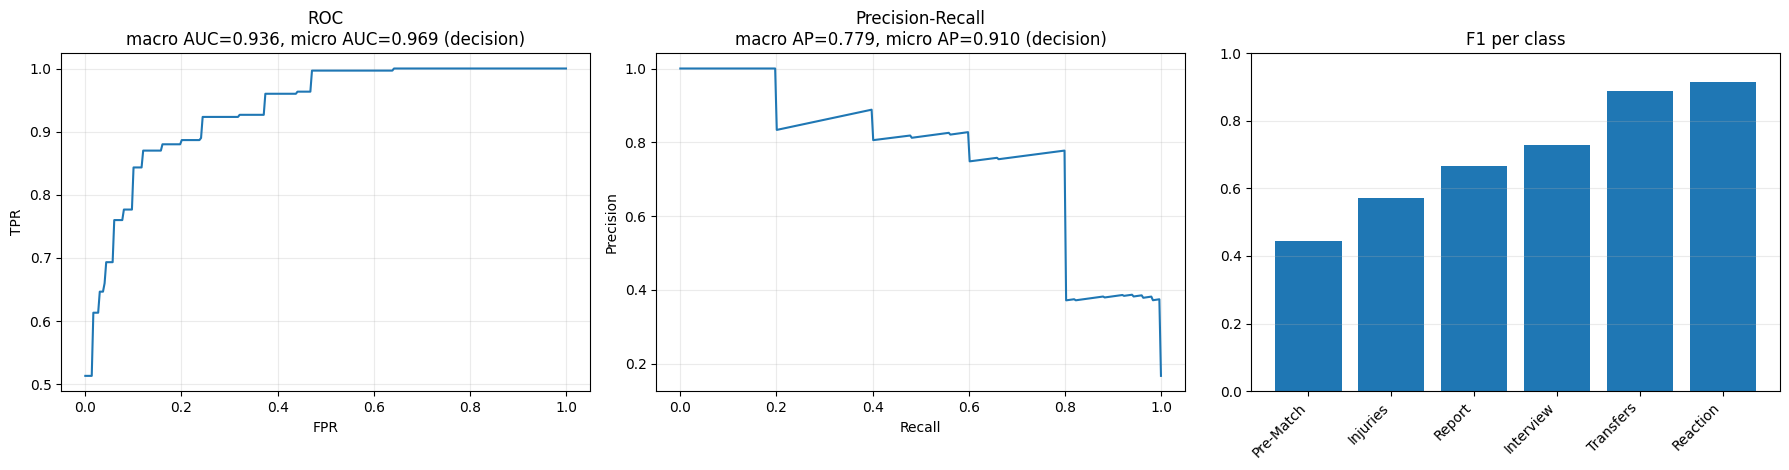

,accuracy,balanced_accuracy,f1_weighted
split,,,
train,0.995833,0.993333,0.995837
test,0.840000,0.660000,0.829437


/Users/kazakovalexey/Documents/Coding/ls_26_2/.venv/lib/python3.12/site-packages/mlflow/models/model.py:1209: FutureWarning: Saving scikit-learn models in the pickle or cloudpickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization.The recommended safe alternative is the 'skops' format.
  flavor.save_model(path=local_path, mlflow_model=mlflow_model, **kwargs)


Run ID: fd8985ab4e324c61b30461eac52e4c63
🏃 View run tfidf_word_1_2_linearsvc_20260216_141541 at: http://127.0.0.1:5000/#/experiments/6/runs/fd8985ab4e324c61b30461eac52e4c63
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/6

🚀 Running experiment: word_1_3


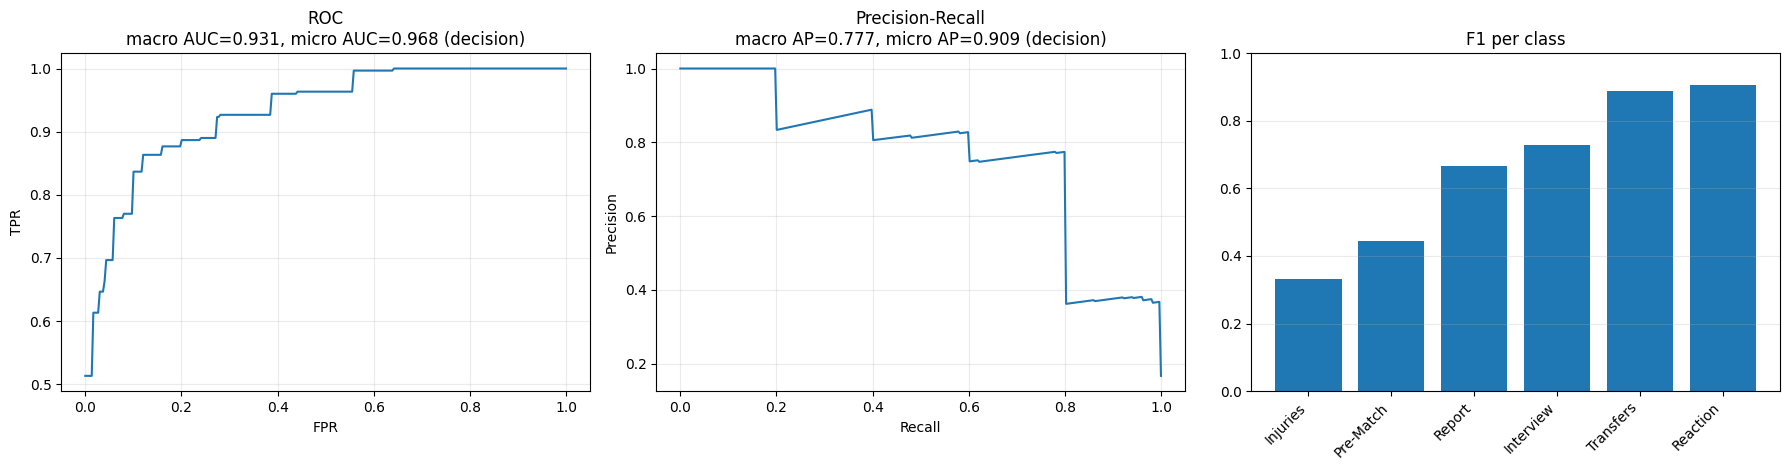

,accuracy,balanced_accuracy,f1_weighted
split,,,
train,0.995833,0.993333,0.995837
test,0.826667,0.626667,0.807814


/Users/kazakovalexey/Documents/Coding/ls_26_2/.venv/lib/python3.12/site-packages/mlflow/models/model.py:1209: FutureWarning: Saving scikit-learn models in the pickle or cloudpickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization.The recommended safe alternative is the 'skops' format.
  flavor.save_model(path=local_path, mlflow_model=mlflow_model, **kwargs)


Run ID: ffaaee03d8b440a597e899e373459dc8
🏃 View run tfidf_word_1_3_linearsvc_20260216_141544 at: http://127.0.0.1:5000/#/experiments/6/runs/ffaaee03d8b440a597e899e373459dc8
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/6

🚀 Running experiment: char3_5_plus_word1_2


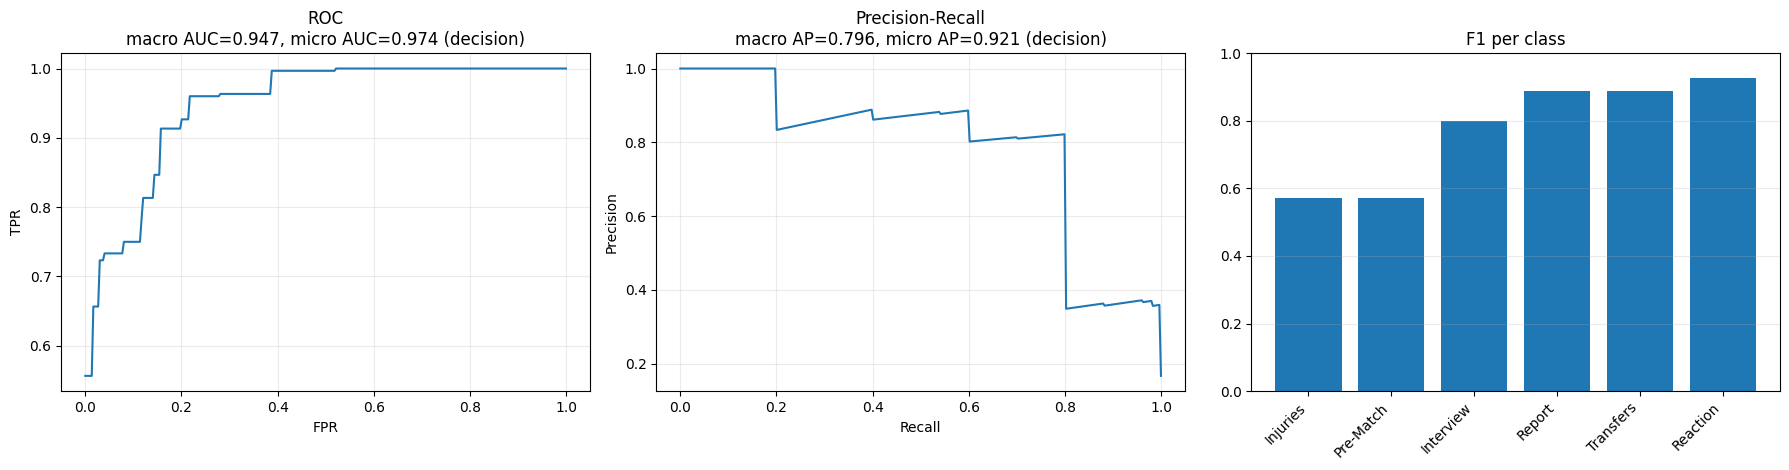

,accuracy,balanced_accuracy,f1_weighted
split,,,
train,0.995833,0.993333,0.995837
test,0.880000,0.700000,0.865326


/Users/kazakovalexey/Documents/Coding/ls_26_2/.venv/lib/python3.12/site-packages/mlflow/models/model.py:1209: FutureWarning: Saving scikit-learn models in the pickle or cloudpickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization.The recommended safe alternative is the 'skops' format.
  flavor.save_model(path=local_path, mlflow_model=mlflow_model, **kwargs)


Run ID: 8df9ca7d30464ad39ed2812bc979d433
🏃 View run tfidf_char3_5_plus_word1_2_linearsvc_20260216_141547 at: http://127.0.0.1:5000/#/experiments/6/runs/8df9ca7d30464ad39ed2812bc979d433
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/6


In [21]:

run_ids = []

for cfg in tfidf_configs:
    print(f"\n🚀 Running experiment: {cfg['name']}")

    # --- build vectorizer
    if cfg["type"] == "single":
        vectorizer = TfidfVectorizer(**cfg["vectorizer"])
    elif cfg["type"] == "union":
        vectorizer = FeatureUnion([
            ("char", TfidfVectorizer(**cfg["vectorizers"]["char"])),
            ("word", TfidfVectorizer(**cfg["vectorizers"]["word"])),
        ])
    else:
        raise ValueError(f"Unknown config type: {cfg['type']}")

    clf = LinearSVC(
        class_weight="balanced",
        random_state=42,
    )

    model = Pipeline([
        ("tfidf", vectorizer),
        ("clf", clf),
    ])

    params = {
        "model_type": "LinearSVC",
        "tfidf_type": cfg["type"],
        "tfidf_name": cfg["name"],
        "class_weight": "balanced",
        "random_state": 42,
        "train_size": len(X_train),
        "valid_size": len(X_val),
        "num_labels": int(pd.Series(y_train).nunique()),
        "source_files": ",".join(sorted(data["source_file"].unique())),
    }

    run_id = run_mlflow_experiment(
        model=model,
        run_name_prefix=f"tfidf_{cfg['name']}_linearsvc",
        params=params,
        X_train=X_train,
        y_train=y_train,
        X_test=X_test,
        y_test=y_test,
        artifacts_dir="artifacts",
        log_model=True,
    )

    run_ids.append((cfg["name"], run_id))


Model s TF-IDF char_wb 3–5 dává nejlepší výsledky, což dává smysl — dobře zachycuje krátké vzory, jména, diakritiku i různé jazyky.

Train 99,5 % ukazuje, že se model výborně naučil tréninková data, a test 88 % / F1 0,865 je velmi solidní výkon.
Nižší balanced accuracy (0,70) znamená, že malé třídy stále dostávají slabší výsledky, což je u nerovnovážného datasetu normální.

Celkově jde o nejlepší a velmi stabilní konfiguraci pro tento typ úlohy.

### Try Logistic regression


 Running LogisticRegression experiment: char_wb_4_6


/Users/kazakovalexey/Documents/Coding/ls_26_2/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1184: FutureWarning: 'n_jobs' has no effect since 1.8 and will be removed in 1.10. You provided 'n_jobs=-1', please leave it unspecified.
  warnings.warn(msg, category=FutureWarning)


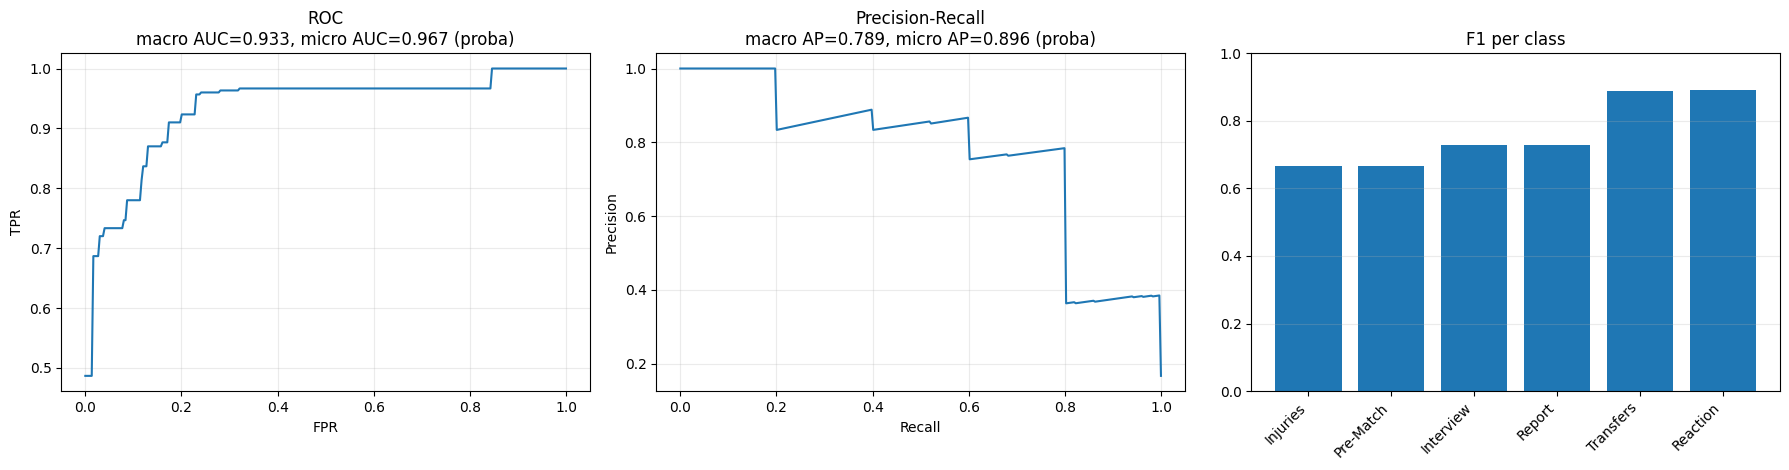

,accuracy,balanced_accuracy,f1_weighted
split,,,
train,0.955833,0.981458,0.956910
test,0.840000,0.750000,0.839177


/Users/kazakovalexey/Documents/Coding/ls_26_2/.venv/lib/python3.12/site-packages/mlflow/models/model.py:1209: FutureWarning: Saving scikit-learn models in the pickle or cloudpickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization.The recommended safe alternative is the 'skops' format.
  flavor.save_model(path=local_path, mlflow_model=mlflow_model, **kwargs)


Run ID: 7b0debeb5af34b09b35f49ed17004a58
🏃 View run tfidf_charwb_4_6_logreg_20260216_141551 at: http://127.0.0.1:5000/#/experiments/6/runs/7b0debeb5af34b09b35f49ed17004a58
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/6
Run ID: 7b0debeb5af34b09b35f49ed17004a58


In [22]:
print("\n Running LogisticRegression experiment: char_wb_4_6")

# --- vectorizer ---
vectorizer = TfidfVectorizer(
    analyzer="char_wb",
    ngram_range=(4, 6),
    min_df=2,
    max_df=0.9,
    lowercase=True,
)

# --- classifier
clf = LogisticRegression(
    max_iter=3000,
    class_weight="balanced",
    n_jobs=-1,
    solver="lbfgs",
    random_state=42,
)

# --- pipeline
model = Pipeline([
    ("tfidf", vectorizer),
    ("clf", clf),
])

# --- params for MLflow
params = {
    "model_type": "LogisticRegression",
    "vectorizer": "TfidfVectorizer(char_wb)",
    "ngram_range": "(4, 6)",
    "min_df": 2,
    "max_df": 0.9,
    "class_weight": "balanced",
    "solver": "lbfgs",
    "max_iter": 3000,
    "random_state": 42,
    "train_size": len(X_train),
    "test_size": len(X_test),
    "num_labels": int(pd.Series(y_train).nunique()),
    "source_files": ",".join(sorted(data["source_file"].unique())),
}

# --- run experiment
run_id = run_mlflow_experiment(
    model=model,
    run_name_prefix="tfidf_charwb_4_6_logreg",
    params=params,
    X_train=X_train,
    y_train=y_train,
    X_test=X_test,
    y_test=y_test,
    artifacts_dir="artifacts",
    log_model=True,
)

print("Run ID:", run_id)

#### Add regularization to logistic regression


Running LogisticRegression experiment (regularized): char_wb_4_6


/Users/kazakovalexey/Documents/Coding/ls_26_2/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1135: FutureWarning: 'penalty' was deprecated in version 1.8 and will be removed in 1.10. To avoid this warning, leave 'penalty' set to its default value and use 'l1_ratio' or 'C' instead. Use l1_ratio=0 instead of penalty='l2', l1_ratio=1 instead of penalty='l1', and C=np.inf instead of penalty=None.
  warnings.warn(
/Users/kazakovalexey/Documents/Coding/ls_26_2/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1184: FutureWarning: 'n_jobs' has no effect since 1.8 and will be removed in 1.10. You provided 'n_jobs=-1', please leave it unspecified.
  warnings.warn(msg, category=FutureWarning)


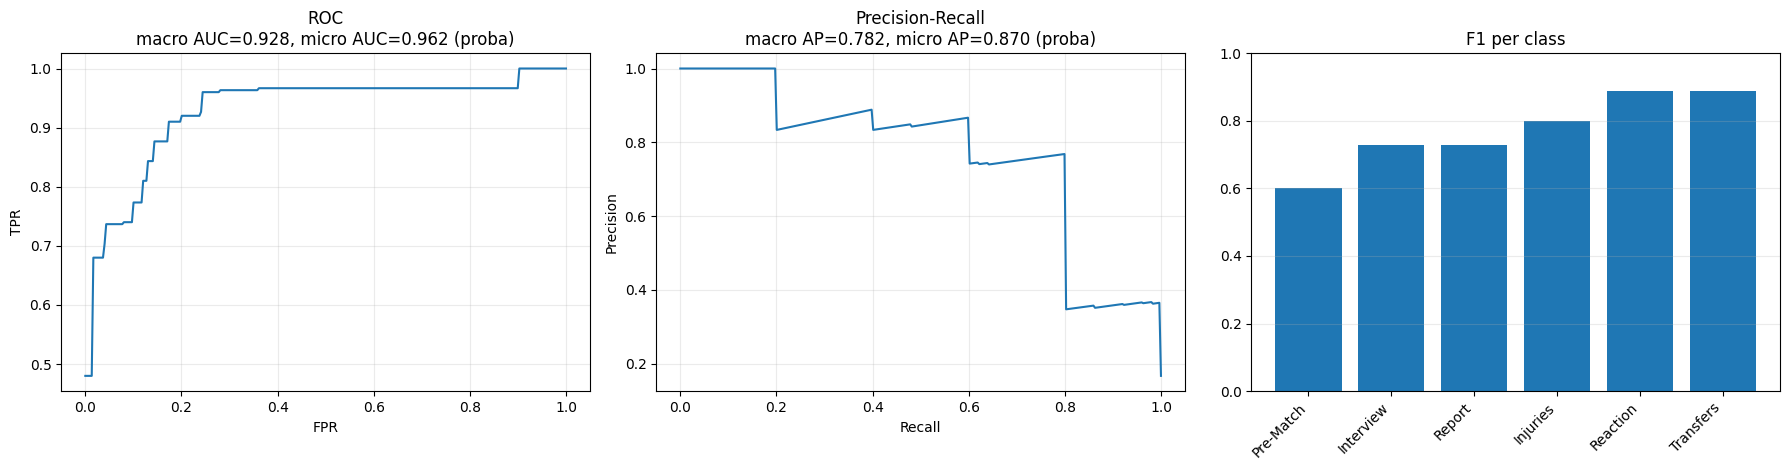

,accuracy,balanced_accuracy,f1_weighted
split,,,
train,0.931667,0.967917,0.934171
test,0.840000,0.780000,0.842155


/Users/kazakovalexey/Documents/Coding/ls_26_2/.venv/lib/python3.12/site-packages/mlflow/models/model.py:1209: FutureWarning: Saving scikit-learn models in the pickle or cloudpickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization.The recommended safe alternative is the 'skops' format.
  flavor.save_model(path=local_path, mlflow_model=mlflow_model, **kwargs)


Run ID: 251e0195910445d591bdc78c81f18f54
🏃 View run tfidf_charwb_4_6_logreg_l2_C0.5_20260216_141555 at: http://127.0.0.1:5000/#/experiments/6/runs/251e0195910445d591bdc78c81f18f54
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/6
Run ID: 251e0195910445d591bdc78c81f18f54


In [23]:
print("\nRunning LogisticRegression experiment (regularized): char_wb_4_6")

# --- vectorizer
vectorizer = TfidfVectorizer(
    analyzer="char_wb",
    ngram_range=(4, 6),
    min_df=2,
    max_df=0.9,
    lowercase=True,
)

# --- classifier (with regularization)
clf = LogisticRegression(
    penalty="l2",
    C=0.5,
    max_iter=3000,
    class_weight="balanced",
    n_jobs=-1,
    solver="lbfgs",
    random_state=42,
)

# --- pipeline
model = Pipeline([
    ("tfidf", vectorizer),
    ("clf", clf),
])

# --- params for MLflow
params = {
    "model_type": "LogisticRegression",
    "vectorizer": "TfidfVectorizer(char_wb)",
    "ngram_range": "(4, 6)",
    "min_df": 2,
    "max_df": 0.9,

    # regularization
    "penalty": "l2",
    "C": 0.5,

    "class_weight": "balanced",
    "solver": "lbfgs",
    "max_iter": 3000,
    "random_state": 42,
    "train_size": len(X_train),
    "test_size": len(X_test),
    "num_labels": int(pd.Series(y_train).nunique()),
    "source_files": ",".join(sorted(data["source_file"].unique())),
}

# --- run experiment
run_id = run_mlflow_experiment(
    model=model,
    run_name_prefix="tfidf_charwb_4_6_logreg_l2_C0.5",
    params=params,
    X_train=X_train,
    y_train=y_train,
    X_test=X_test,
    y_test=y_test,
    artifacts_dir="artifacts",
    log_model=True,
)

print("Run ID:", run_id)


Tady regularizace pomohla, ale stále jsme pod SVM.

### Try Naive Bayes


 Running ComplementNB experiment: char_wb_4_6


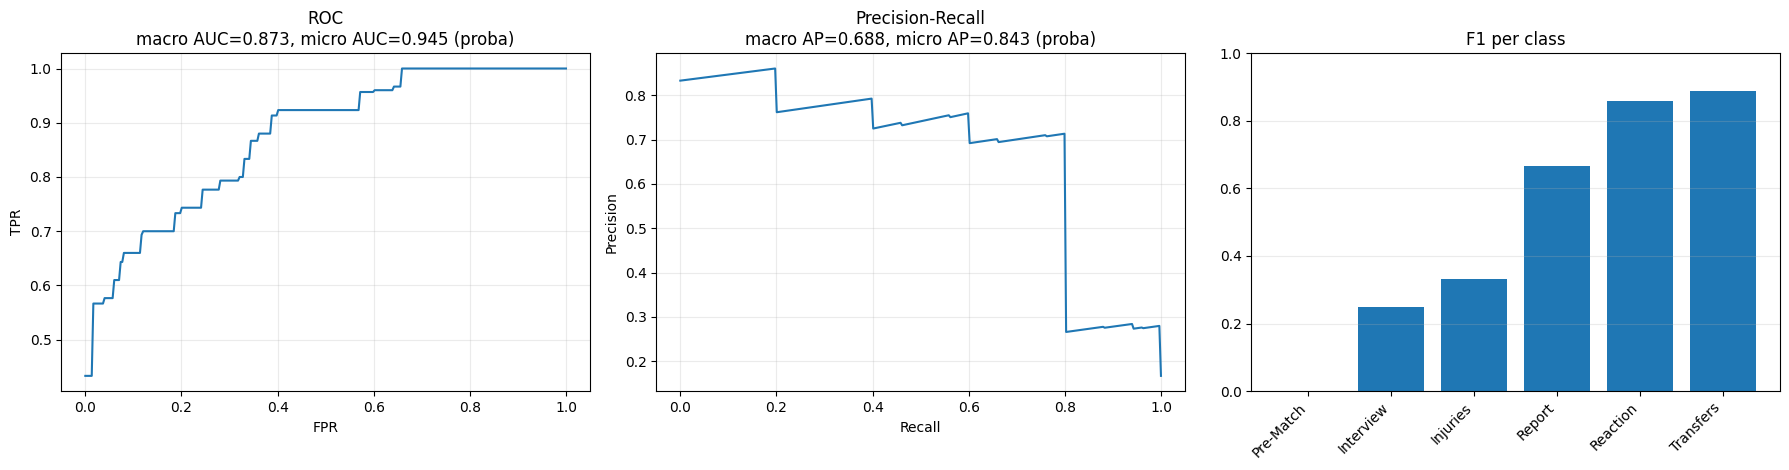

,accuracy,balanced_accuracy,f1_weighted
split,,,
train,0.931667,0.857292,0.929943
test,0.760000,0.460000,0.714021


/Users/kazakovalexey/Documents/Coding/ls_26_2/.venv/lib/python3.12/site-packages/mlflow/models/model.py:1209: FutureWarning: Saving scikit-learn models in the pickle or cloudpickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization.The recommended safe alternative is the 'skops' format.
  flavor.save_model(path=local_path, mlflow_model=mlflow_model, **kwargs)


Run ID: b2c8de5ef5de4ed4b23d3bf4498ce7e0
🏃 View run tfidf_charwb_4_6_cnb_20260216_141559 at: http://127.0.0.1:5000/#/experiments/6/runs/b2c8de5ef5de4ed4b23d3bf4498ce7e0
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/6

 Finished ComplementNB experiment
Run ID: b2c8de5ef5de4ed4b23d3bf4498ce7e0


In [24]:
print("\n Running ComplementNB experiment: char_wb_4_6")

# --- vectorizer (direct, no config indirection)
vectorizer = TfidfVectorizer(
    analyzer="char_wb",
    ngram_range=(4, 6),
    min_df=2,
    max_df=0.9,
    lowercase=True,
)

# --- classifier
clf = ComplementNB(alpha=0.5)

# --- pipeline
model = Pipeline([
    ("tfidf", vectorizer),
    ("clf", clf),
])

# --- params for MLflow
params = {
    "model_type": "ComplementNB",
    "vectorizer": "TfidfVectorizer(char_wb)",
    "ngram_range": "(4, 6)",
    "min_df": 2,
    "max_df": 0.9,
    "alpha": 0.5,
    "train_size": len(X_train),
    "test_size": len(X_test),
    "num_labels": int(pd.Series(y_train).nunique()),
    "source_files": ",".join(sorted(data["source_file"].unique())),
}

# --- run experiment
run_id = run_mlflow_experiment(
    model=model,
    run_name_prefix="tfidf_charwb_4_6_cnb",
    params=params,
    X_train=X_train,
    y_train=y_train,
    X_test=X_test,
    y_test=y_test,
    artifacts_dir="artifacts",
    log_model=True,
)

print("\n Finished ComplementNB experiment")
print("Run ID:", run_id)


#### Try regularization for Naive Bayes


 Running ComplementNB experiment (regularized): char_wb_4_6


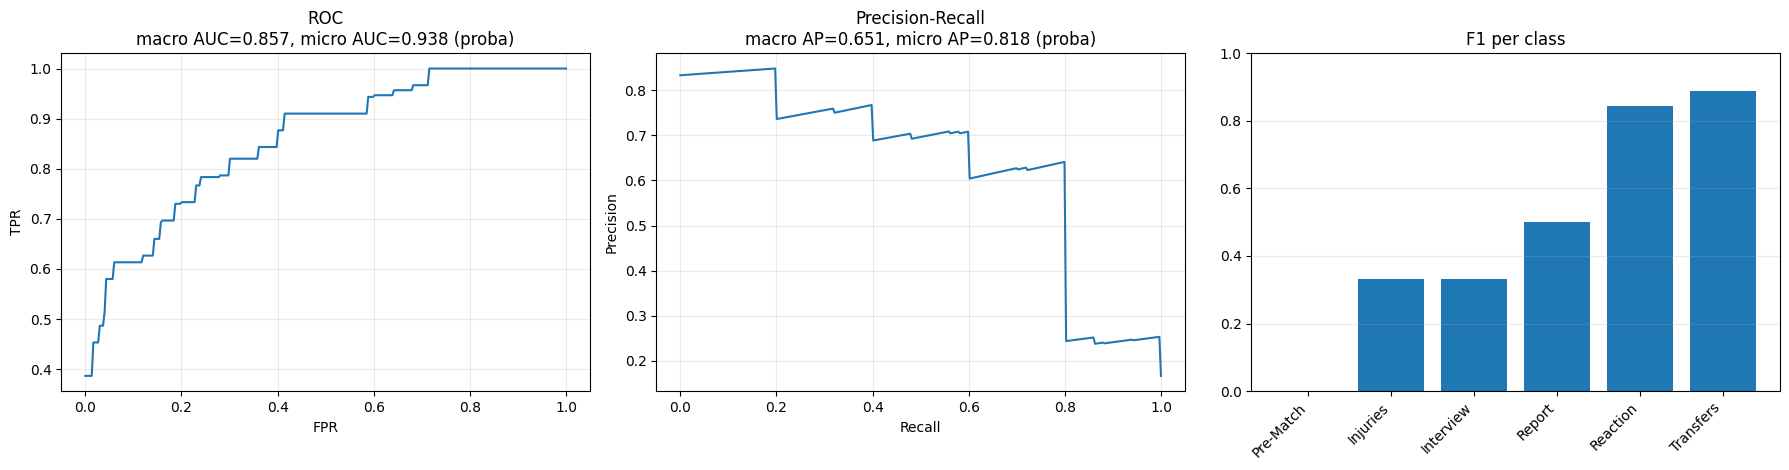

,accuracy,balanced_accuracy,f1_weighted
split,,,
train,0.89,0.749375,0.883218
test,0.76,0.430000,0.700255


/Users/kazakovalexey/Documents/Coding/ls_26_2/.venv/lib/python3.12/site-packages/mlflow/models/model.py:1209: FutureWarning: Saving scikit-learn models in the pickle or cloudpickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization.The recommended safe alternative is the 'skops' format.
  flavor.save_model(path=local_path, mlflow_model=mlflow_model, **kwargs)


Run ID: 2c116a780e494b3cb61a9e51a1ec8291
🏃 View run tfidf_charwb_4_6_cnb_reg_20260216_141602 at: http://127.0.0.1:5000/#/experiments/6/runs/2c116a780e494b3cb61a9e51a1ec8291
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/6

 Finished ComplementNB experiment
Run ID: 2c116a780e494b3cb61a9e51a1ec8291


In [25]:
print("\n Running ComplementNB experiment (regularized): char_wb_4_6")

# --- vectorizer ---
vectorizer = TfidfVectorizer(
    analyzer="char_wb",
    ngram_range=(4, 6),
    min_df=2,
    max_df=0.9,
    lowercase=True,
    norm="l2",
    sublinear_tf=True,
)

# --- classifier ---
clf = ComplementNB(
    alpha=1.0,
    fit_prior=True,
)

# --- pipeline
model = Pipeline([
    ("tfidf", vectorizer),
    ("clf", clf),
])

# --- params for MLflow
params = {
    "model_type": "ComplementNB",
    "vectorizer": "TfidfVectorizer(char_wb)",
    "ngram_range": "(4, 6)",
    "min_df": 2,
    "max_df": 0.9,
    "norm": "l2",
    "sublinear_tf": True,

    # regularization
    "alpha": 1.0,
    "fit_prior": True,

    "train_size": len(X_train),
    "test_size": len(X_test),
    "num_labels": int(pd.Series(y_train).nunique()),
    "source_files": ",".join(sorted(data["source_file"].unique())),
}

# --- run experiment
run_id = run_mlflow_experiment(
    model=model,
    run_name_prefix="tfidf_charwb_4_6_cnb_reg",
    params=params,
    X_train=X_train,
    y_train=y_train,
    X_test=X_test,
    y_test=y_test,
    artifacts_dir="artifacts",
    log_model=True,
)

print("\n Finished ComplementNB experiment")
print("Run ID:", run_id)


### Try SGD Classifier


Running SGDClassifier experiment: char_wb_4_6


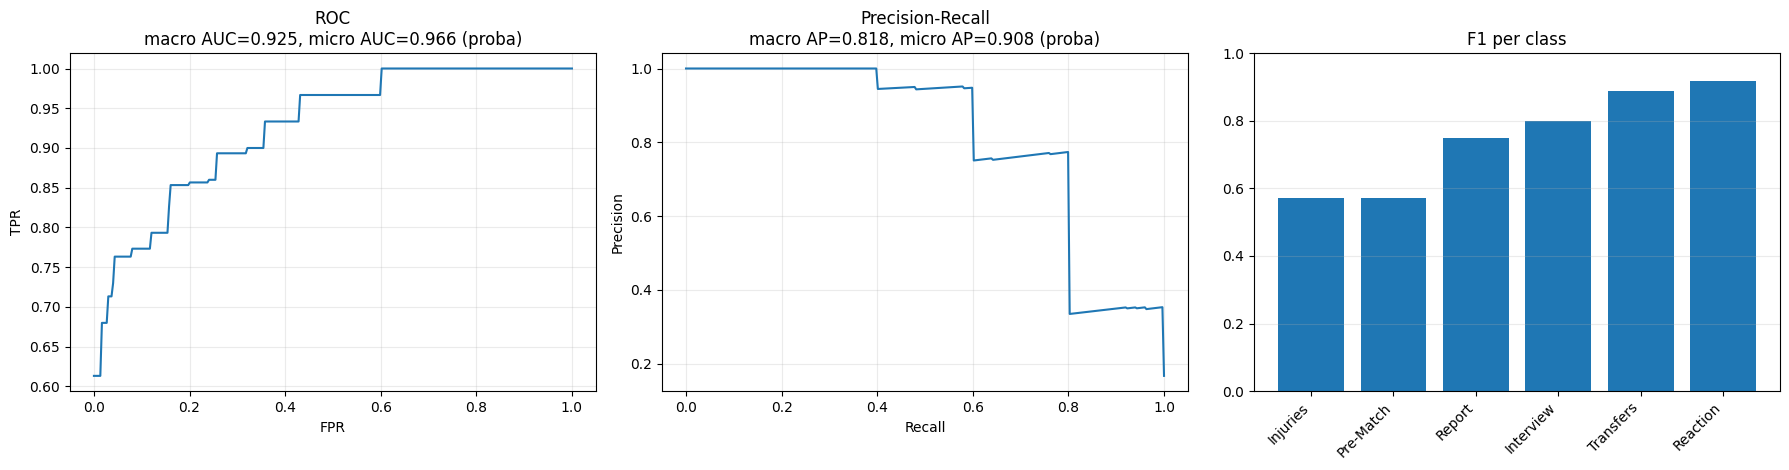

,accuracy,balanced_accuracy,f1_weighted
split,,,
train,0.994167,0.989167,0.994200
test,0.866667,0.666667,0.850404


/Users/kazakovalexey/Documents/Coding/ls_26_2/.venv/lib/python3.12/site-packages/mlflow/models/model.py:1209: FutureWarning: Saving scikit-learn models in the pickle or cloudpickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization.The recommended safe alternative is the 'skops' format.
  flavor.save_model(path=local_path, mlflow_model=mlflow_model, **kwargs)


Run ID: d39f09e7cd61495e946ccc762bdea967
🏃 View run tfidf_charwb_4_6_sgd_20260216_141606 at: http://127.0.0.1:5000/#/experiments/6/runs/d39f09e7cd61495e946ccc762bdea967
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/6

Finished SGDClassifier experiment
Run ID: d39f09e7cd61495e946ccc762bdea967


In [26]:
print("\nRunning SGDClassifier experiment: char_wb_4_6")

# --- vectorizer ---
vectorizer = TfidfVectorizer(
    analyzer="char_wb",
    ngram_range=(4, 6),
    min_df=2,
    max_df=0.9,
    lowercase=True,
)

# --- classifier
clf = SGDClassifier(
    loss="log_loss",
    alpha=1e-5,
    max_iter=2000,
    tol=1e-3,
    class_weight="balanced",
    random_state=42,
)

# --- pipeline
model = Pipeline([
    ("tfidf", vectorizer),
    ("clf", clf),
])

# --- params for MLflow
params = {
    "model_type": "SGDClassifier",
    "vectorizer": "TfidfVectorizer(char_wb)",
    "ngram_range": "(4, 6)",
    "min_df": 2,
    "max_df": 0.9,
    "loss": "log_loss",
    "alpha": 1e-5,
    "max_iter": 2000,
    "tol": 1e-3,
    "class_weight": "balanced",
    "random_state": 42,
    "train_size": len(X_train),
    "test_size": len(X_test),
    "num_labels": int(pd.Series(y_train).nunique()),
    "source_files": ",".join(sorted(data["source_file"].unique())),
}

# --- run experiment
run_id = run_mlflow_experiment(
    model=model,
    run_name_prefix="tfidf_charwb_4_6_sgd",
    params=params,
    X_train=X_train,
    y_train=y_train,
    X_test=X_test,
    y_test=y_test,
    artifacts_dir="artifacts",
    log_model=True,
)

print("\nFinished SGDClassifier experiment")
print("Run ID:", run_id)


### Try XGBoost

In [27]:
print("\nRunning LightGBM experiment (with regularization): char_wb_4_6")

# --- vectorizer ---
vectorizer = TfidfVectorizer(
    analyzer="char_wb",
    ngram_range=(4, 6),
    min_df=2,
    max_df=0.9,
    lowercase=True,
    max_features=20000,
)

# --- classifier (with regularization)
clf = LGBMClassifier(
    objective="multiclass",
    n_estimators=600,
    learning_rate=0.05,
    num_leaves=63,
    subsample=0.9,
    colsample_bytree=0.8,

    # Regularization
    reg_alpha=0.5,
    reg_lambda=2.0,
    min_child_samples=30,
    min_split_gain=0.0,
    max_depth=-1,

    class_weight="balanced",
    random_state=42,
    n_jobs=-1,
)

# --- pipeline
model = Pipeline([
    ("tfidf", vectorizer),
    ("clf", clf),
])

# --- params for MLflow
params = {
    "model_type": "LGBMClassifier",
    "vectorizer": "TfidfVectorizer(char_wb)",
    "ngram_range": "(4, 6)",
    "min_df": 2,
    "max_df": 0.9,
    "max_features": 20000,

    "objective": "multiclass",
    "n_estimators": 600,
    "learning_rate": 0.05,
    "num_leaves": 63,
    "subsample": 0.9,
    "colsample_bytree": 0.8,

    # regularization
    "reg_alpha": 0.5,
    "reg_lambda": 2.0,
    "min_child_samples": 30,
    "min_split_gain": 0.0,
    "max_depth": -1,

    "class_weight": "balanced",
    "random_state": 42,
    "train_size": len(X_train),
    "test_size": len(X_test),
    "num_labels": int(pd.Series(y_train).nunique()),
    "source_files": ",".join(sorted(data["source_file"].unique())),
}

# --- run experiment
run_id = run_mlflow_experiment(
    model=model,
    run_name_prefix="tfidf_charwb_4_6_lgbm_cap20k_reg",
    params=params,
    X_train=X_train,
    y_train=y_train,
    X_test=X_test,
    y_test=y_test,
    artifacts_dir="artifacts",
    log_model=True,
)

print("\n Finished LightGBM experiment")
print("Run ID:", run_id)



Running LightGBM experiment (with regularization): char_wb_4_6


NameError: name 'LGBMClassifier' is not defined

### Try Downsampling "Reaction" label

In [ ]:
print("Original label counts:")
print(data["label"].value_counts())

# Separate Reaction and others
reaction_df = data[data["label"] == "Reaction"]
other_df = data[data["label"] != "Reaction"]

# Remove 900 Reaction rows (keep 100)
reaction_ds = reaction_df.sample(
    n=len(reaction_df) - 900,
    random_state=42
)

# Merge back
data_ds = pd.concat([reaction_ds, other_df]).sample(
    frac=1, random_state=42
).reset_index(drop=True)

print("\nAfter downsampling:")
print(data_ds["label"].value_counts())


Original label counts:
label
Reaction     1000
Injuries      100
Interview     100
Pre-Match     100
Report        100
Transfers     100
Name: count, dtype: int64

After downsampling:
label
Injuries     100
Report       100
Transfers    100
Reaction     100
Interview    100
Pre-Match    100
Name: count, dtype: int64


In [ ]:
X_ds = data_ds["text"].values
y_ds = data_ds["label"].values


X_ds_train, X_ds_temp, y_ds_train, y_ds_temp = train_test_split(
    X_ds, y_ds, test_size=0.2, random_state=42, stratify=y_ds
)

X_ds_val, X_ds_test, y_ds_val, y_ds_test = train_test_split(
    X_ds_temp, y_ds_temp, test_size=0.25, random_state=42, stratify=y_ds_temp
)

print("DS Train:", len(X_ds_train))
print("DS Valid:", len(X_ds_val))
print("DS Test :", len(X_ds_test))


DS Train: 480
DS Valid: 90
DS Test : 30


#### Train SVC with downsampled dataset


🚀 Running LinearSVC experiment with downsampled dataset: char_wb_4_6


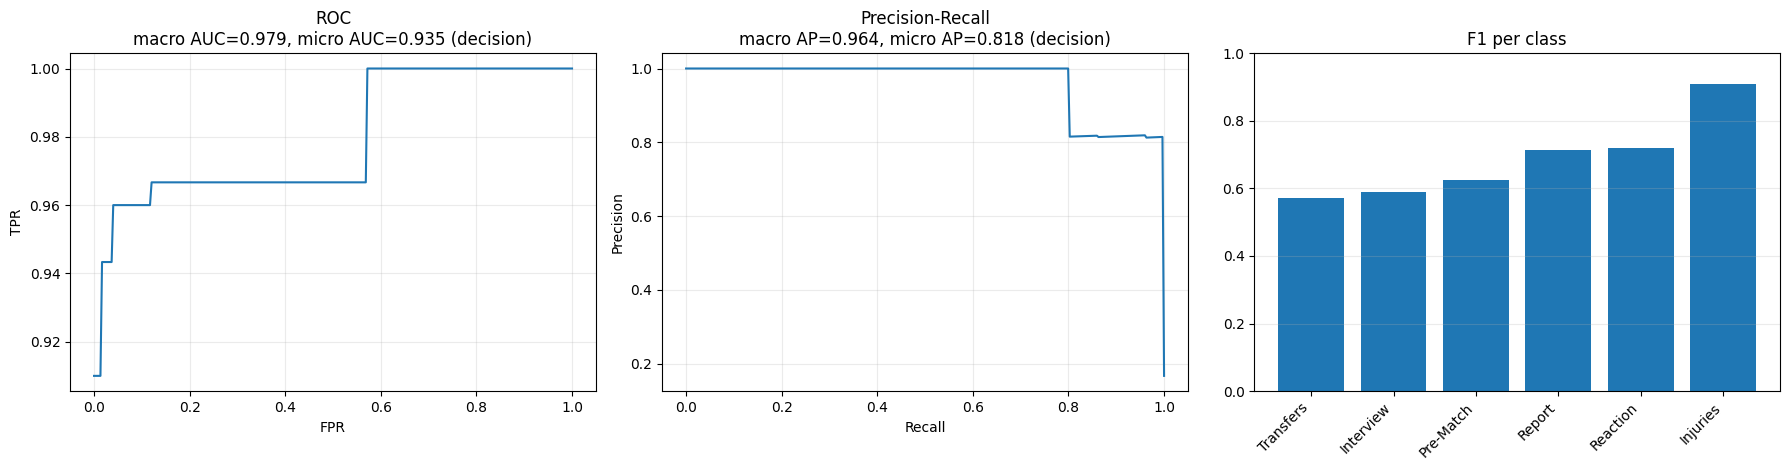

,accuracy,balanced_accuracy,f1_weighted
split,,,
train,0.997917,0.997917,0.997917
test,0.693333,0.893333,0.705835


/Users/kazakovalexey/Documents/Coding/ls_26_2/.venv/lib/python3.12/site-packages/mlflow/models/model.py:1209: FutureWarning: Saving scikit-learn models in the pickle or cloudpickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization.The recommended safe alternative is the 'skops' format.
  flavor.save_model(path=local_path, mlflow_model=mlflow_model, **kwargs)


Run ID: bd099f9863ca4d30997ef095f69675d8
🏃 View run tfidf_charwb_4_6_linearsvc_downsampled_20260216_131944 at: http://127.0.0.1:5000/#/experiments/6/runs/bd099f9863ca4d30997ef095f69675d8
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/6

✅ Finished downsampled LinearSVC experiment
Run ID: bd099f9863ca4d30997ef095f69675d8


In [ ]:
print("\n Running LinearSVC experiment with downsampled dataset: char_wb_4_6")

# --- vectorizer (direct, no config indirection)
vectorizer = TfidfVectorizer(
    analyzer="char_wb",
    ngram_range=(4, 6),
    min_df=2,
    max_df=0.9,
    lowercase=True,
)

# --- classifier
clf = LinearSVC(
    class_weight="balanced",
    random_state=42,
    max_iter=20000,
)

# --- pipeline
model = Pipeline([
    ("tfidf", vectorizer),
    ("clf", clf),
])

# --- params for MLflow
params = {
    "model_type": "LinearSVC",
    "vectorizer": "TfidfVectorizer(char_wb)",
    "ngram_range": "(4, 6)",
    "min_df": 2,
    "max_df": 0.9,
    "class_weight": "balanced",
    "random_state": 42,
    "train_size": len(X_ds_train),
    "test_size": len(X_test),
    "num_labels": int(pd.Series(y_ds_train).nunique()),
    "source_files": ",".join(sorted(data_ds["source_file"].unique())),
    "dataset": "downsampled",
}

# --- run experiment
run_id = run_mlflow_experiment(
    model=model,
    run_name_prefix="tfidf_charwb_4_6_linearsvc_downsampled",
    params=params,
    X_train=X_ds_train,
    y_train=y_ds_train,
    X_test=X_test,
    y_test=y_test,
    artifacts_dir="artifacts",
    log_model=True,
)

print("\n Finished downsampled LinearSVC experiment")
print("Run ID:", run_id)


## Hyperparameter tunning

### Tyne parameters for SVC

In [ ]:
base_model = Pipeline([
    ("tfidf", TfidfVectorizer(
        analyzer="char_wb",
        ngram_range=(4, 6),
        min_df=2,
        max_df=0.9,
        lowercase=True,
        norm="l2",
    )),
    ("clf", LinearSVC(
        class_weight="balanced",
        random_state=42,
    )),
])

param_grid = {
    "tfidf__sublinear_tf": [True, False],
    "tfidf__max_features": [None,2000, 3000, 5000, 10000, 20000, 40000, 60000],
    "tfidf__min_df": [2, 3],
    "clf__C": [0.3, 1.0, 3.0, 10.0],
    "clf__loss": ["squared_hinge"],
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

grid = GridSearchCV(
    base_model,
    param_grid=param_grid,
    scoring="f1_macro",
    cv=cv,
    n_jobs=-1,
    refit=True,
)

grid.fit(X_train, y_train)

print("Best CV macro-F1:", grid.best_score_)
print("Best params:", grid.best_params_)

best_model = grid.best_estimator_


/Users/kazakovalexey/Documents/Coding/ls_26_2/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:1258: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/kazakovalexey/Documents/Coding/ls_26_2/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:1258: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/kazakovalexey/Documents/Coding/ls_26_2/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:1258: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/kazakovalexey/Documents/Coding/ls_26_2/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:1258: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/kazakovalexey/Documents/Coding/ls_26_2/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:1258: ConvergenceWarning: Liblinear failed to converge, in

Best CV macro-F1: 0.6709938147229415
Best params: {'clf__C': 1.0, 'clf__loss': 'squared_hinge', 'tfidf__max_features': None, 'tfidf__min_df': 2, 'tfidf__sublinear_tf': True}


In [ ]:
# baseline
baseline = base_model
baseline.fit(X_train, y_train)
baseline_pred = baseline.predict(X_val)
baseline_f1 = f1_score(y_val, baseline_pred, average="macro")

# grid best
grid_pred = best_model.predict(X_val)
grid_f1 = f1_score(y_val, grid_pred, average="macro")

print(f"Baseline val macro-F1: {baseline_f1:.4f}")
print(f"Grid-best val macro-F1: {grid_f1:.4f}")


Baseline val macro-F1: 0.7741
Grid-best val macro-F1: 0.7789


#### Log best model to MLFlow

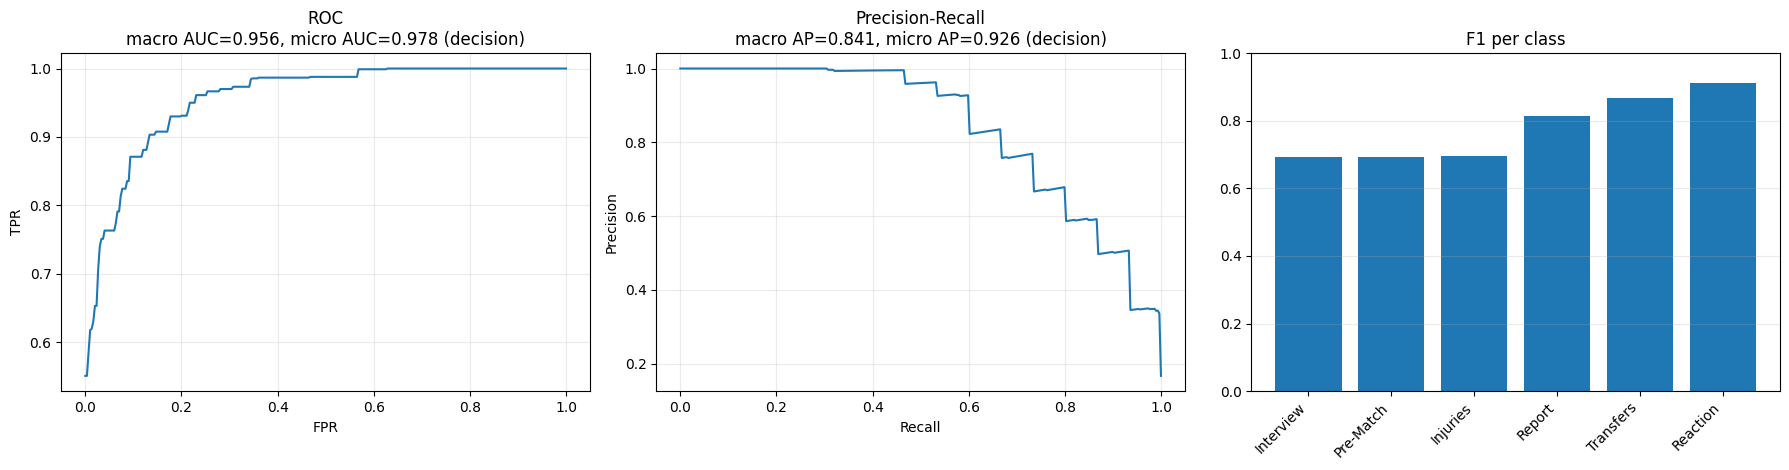

,accuracy,balanced_accuracy,f1_weighted
split,,,
val,0.866667,0.716667,0.85875


Validation run ID: f1d13ddd52db4acba53f8f56049ebb69
🏃 View run best_charwb_4_6_linearsvc_validation_20260216_135036 at: http://127.0.0.1:5000/#/experiments/6/runs/f1d13ddd52db4acba53f8f56049ebb69
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/6
Validation Run ID: f1d13ddd52db4acba53f8f56049ebb69


In [ ]:
params = {
    "model_type": "LinearSVC",
    "tfidf_analyzer": "char_wb",
    "ngram_range": str((4, 6)),
    "class_weight": "balanced",
    "random_state": 42,

    # CV info
    "grid_best_cv_f1_macro": float(grid.best_score_),
    **{f"best__{k}": str(v) for k, v in grid.best_params_.items()},
}

run_id = run_mlflow_validation_only(
    model=best_model,
    run_name_prefix="best_charwb_4_6_linearsvc_validation",
    params=params,
    X_val=X_val,
    y_val=y_val,
    artifacts_dir="artifacts",
)

print("Validation Run ID:", run_id)


### Tune parameters for Logistic Regression

In [ ]:
print("\n GridSearchCV: LogisticRegression (char_wb_4_6)")

# --- Base pipeline ---
pipe = Pipeline([
    ("tfidf", TfidfVectorizer(
        analyzer="char_wb",
        ngram_range=(4, 6),
        min_df=2,
        max_df=0.9,
        lowercase=True,
    )),
    ("clf", LogisticRegression(
        max_iter=4000,
        class_weight="balanced",
        solver="saga", 
        n_jobs=-1,
        random_state=42,
    )),
])

# --- Param grid ---
param_grid = {
    "tfidf__sublinear_tf": [True, False],
    "tfidf__max_features": [None,2000, 3000, 5000, 10000, 20000, 40000, 60000],
    "clf__C": [0.5, 1.0, 2.0],
    "clf__penalty": ["l2", "elasticnet"],
    "clf__l1_ratio": [None, 0.1, 0.5],
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

grid = GridSearchCV(
    pipe,
    param_grid=param_grid,
    scoring="f1_macro",
    cv=cv,
    n_jobs=-1,
    refit=True,
)

grid.fit(X_train, y_train)

print("\n Best CV F1_macro:", grid.best_score_)
print(" Best params:", grid.best_params_)

best_model = grid.best_estimator_



🔍 GridSearchCV: LogisticRegression (char_wb_4_6)


/Users/kazakovalexey/Documents/Coding/ls_26_2/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1135: FutureWarning: 'penalty' was deprecated in version 1.8 and will be removed in 1.10. To avoid this warning, leave 'penalty' set to its default value and use 'l1_ratio' or 'C' instead. Use l1_ratio=0 instead of penalty='l2', l1_ratio=1 instead of penalty='l1', and C=np.inf instead of penalty=None.
  warnings.warn(
/Users/kazakovalexey/Documents/Coding/ls_26_2/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1160: UserWarning: Inconsistent values: penalty=l2 with l1_ratio=None. penalty is deprecated. Please use l1_ratio only.
  warnings.warn(
/Users/kazakovalexey/Documents/Coding/ls_26_2/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1184: FutureWarning: 'n_jobs' has no effect since 1.8 and will be removed in 1.10. You provided 'n_jobs=-1', please leave it unspecified.
  warnings.warn(msg, category=FutureWarning)
/Users/kazakova


🏆 Best CV F1_macro: 0.6748719861128138
🏆 Best params: {'clf__C': 2.0, 'clf__l1_ratio': None, 'clf__penalty': 'l2', 'tfidf__max_features': None, 'tfidf__sublinear_tf': True}


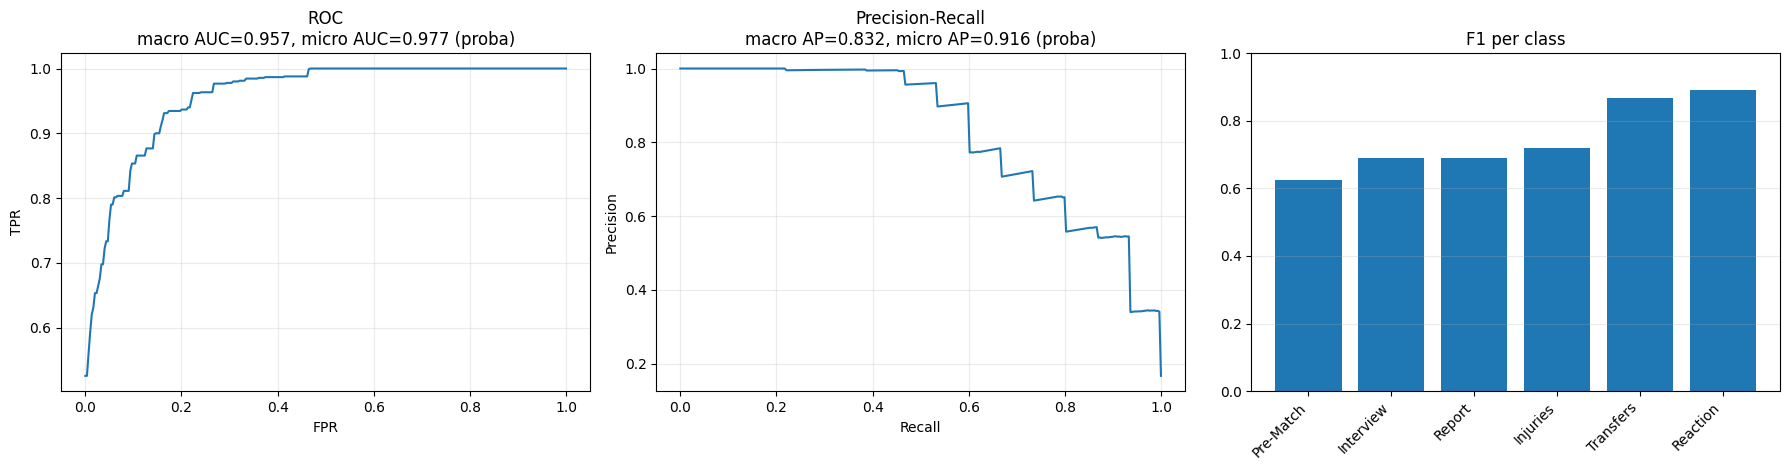

,accuracy,balanced_accuracy,f1_weighted
split,,,
val,0.835556,0.728889,0.833934


Validation run ID: d034c661acbe4f2dafe4983424522af5
🏃 View run tfidf_charwb_4_6_logreg_best_grid_validation_20260216_140053 at: http://127.0.0.1:5000/#/experiments/6/runs/d034c661acbe4f2dafe4983424522af5
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/6
✅ Best LogisticRegression model evaluated on validation set
Validation Run ID: d034c661acbe4f2dafe4983424522af5


In [ ]:
best_model = grid.best_estimator_

# --- MLflow params ---
params = {
    "model_type": "LogisticRegression",
    "vectorizer": "TfidfVectorizer(char_wb)",
    "ngram_range": "(4, 6)",
    "min_df": 2,
    "max_df": 0.9,
    "lowercase": True,

    # best hyperparameters from GridSearch
    **{f"best__{k}": str(v) for k, v in grid.best_params_.items()},

    # CV info
    "cv_scoring": "f1_macro",
    "cv_f1_macro_mean": float(grid.best_score_),

    "solver": "saga",
    "class_weight": "balanced",
    "random_state": 42,

    "num_labels": int(pd.Series(y_train).nunique()),
    "train_size": len(X_train),
    "val_size": len(X_val),
    "source_files": ",".join(sorted(data["source_file"].unique())),
}

# --- Run MLflow evaluation ---
run_id = run_mlflow_validation_only(
    model=best_model,
    run_name_prefix="tfidf_charwb_4_6_logreg_best_grid_validation",
    params=params,
    X_val=X_val,
    y_val=y_val,
    artifacts_dir="artifacts",
)

print(" Best LogisticRegression model evaluated on validation set")
print("Validation Run ID:", run_id)


### Tune parameters for SGD

In [ ]:
# --- base pipeline
pipe = Pipeline([
    ("tfidf", TfidfVectorizer(
        analyzer="char_wb",
        ngram_range=(4, 6),
        min_df=2,
        max_df=0.9,
        lowercase=True,
        norm="l2",
    )),
    ("clf", SGDClassifier(
        loss="log_loss",
        class_weight="balanced",
        random_state=42,
    )),
])

# --- SMALL, meaningful grid
param_grid = {
    "tfidf__sublinear_tf": [False, True],
    "tfidf__max_features": [None,2000, 3000, 5000, 10000, 20000, 40000, 60000],
    "clf__penalty": ["l2", "elasticnet"],
    "clf__alpha": [1e-5, 1e-4, 1e-3],
    "clf__l1_ratio": [0.1, 0.2],
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

grid = GridSearchCV(
    estimator=pipe,
    param_grid=param_grid,
    scoring="f1_macro",
    cv=cv,
    n_jobs=-1,
    refit=True,
)

print("🔎 Running GridSearchCV on TRAIN...")
grid.fit(X_train, y_train)

print("\n🏆 Best CV score:", grid.best_score_)
print("🏆 Best params:")
print(grid.best_params_)


🔎 Running GridSearchCV on TRAIN...

🏆 Best CV score: 0.6506083896535375
🏆 Best params:
{'clf__alpha': 1e-05, 'clf__l1_ratio': 0.1, 'clf__penalty': 'l2', 'tfidf__max_features': None, 'tfidf__sublinear_tf': False}


#### Log best model to MLFlow

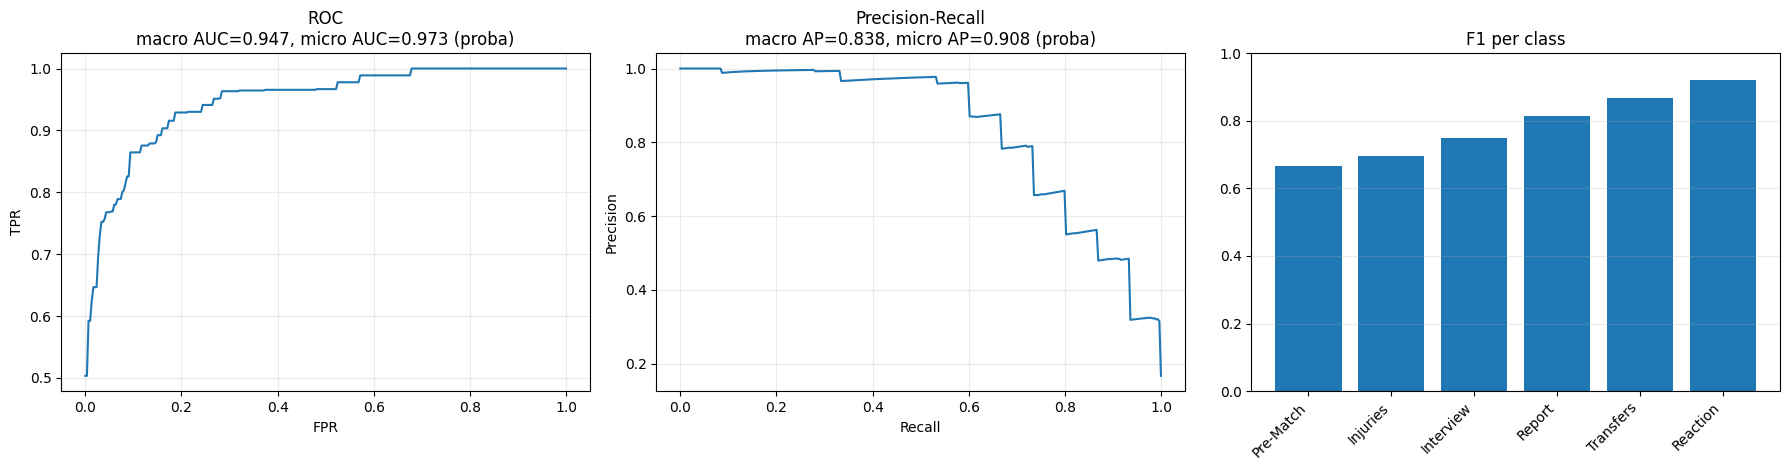

,accuracy,balanced_accuracy,f1_weighted
split,,,
val,0.875556,0.708889,0.865756


Validation run ID: 35d5b5ad81574081a37148cbff4a8425
🏃 View run tfidf_charwb_4_6_sgd_best_grid_validation_20260216_140400 at: http://127.0.0.1:5000/#/experiments/6/runs/35d5b5ad81574081a37148cbff4a8425
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/6
✅ Best SGD model evaluated on validation set
Validation Run ID: 35d5b5ad81574081a37148cbff4a8425


In [ ]:
best_model = grid.best_estimator_

params = {
    "model_type": "SGDClassifier",
    "vectorizer": "TfidfVectorizer(char_wb)",
    "ngram_range": "(4, 6)",
    "min_df": 2,
    "max_df": 0.9,
    "norm": "l2",

    # best hyperparameters from GridSearch
    **{f"best__{k}": str(v) for k, v in grid.best_params_.items()},

    # CV info
    "cv_scoring": "f1_macro",
    "cv_f1_macro_mean": float(grid.best_score_),

    "class_weight": "balanced",
    "random_state": 42,
    "num_labels": int(pd.Series(y_train).nunique()),
    "source_files": ",".join(sorted(data["source_file"].unique())),
}

run_id = run_mlflow_validation_only(
    model=best_model,   
    run_name_prefix="tfidf_charwb_4_6_sgd_best_grid_validation",
    params=params,
    X_val=X_val,
    y_val=y_val,
    artifacts_dir="artifacts",
)

print("Best SGD model evaluated on validation set")
print("Validation Run ID:", run_id)


Po provedení grid search a ladění hyperparametrů se jako nejvýkonnější ukázal model SGDClassifier, který dosáhl nejlepších výsledků na validační sadě. V dalším postupu proto pokračujeme s tímto modelem.

## Save and Register the best Model

In [ ]:
# --- MLflow: Register the model ---
model_uri = f"runs:/{run_id}/model"
registered_model_name = "text_cls_best_sgd"

result = mlflow.register_model(
    model_uri=model_uri,
    name=registered_model_name
)

print("📦 Model registered!")
print(f"Model name: {registered_model_name}")
print(f"Version: {result.version}")


# -----------------------------------------------------
#  Save the trained model locally to folder: model/
# -----------------------------------------------------
local_model_dir = "model"
os.makedirs(local_model_dir, exist_ok=True)

# 1) Save in pickle format
pickle_path = os.path.join(local_model_dir, "best_sgd_model.pkl")
joblib.dump(best_model, pickle_path)
print(f" Model saved locally as pickle: {pickle_path}")

# 2) Save in MLflow model format (directory with MLmodel file)
mlflow_local_path = os.path.join(local_model_dir, "mlflow_model")
mlflow.sklearn.save_model(best_model, path=mlflow_local_path)
print(f"MLflow model folder saved to: {mlflow_local_path}")
